<a href="https://colab.research.google.com/github/etckanikama/practice-repository/blob/main/reservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(100, 1)


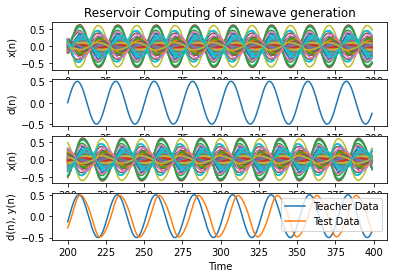

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import random

unit = 100 # 内部ユニットの個数
T0 = 100 #初期の過渡時間
T1 = 200 #学習時間
T2 = 200 #テスト時間
alpha = 0.8 # 縮尺パラメータ
ramda = 0.1 # 正規化パラメータ

#教師データ
def teacher(n):
  return 0.5*np.sin(n/4.0)

##### 準備 #####
time = [] #空の時間配列
d = [] #からの教師配列
for i in range(T1): # 0~199 まで回す
  time.append(i) #時間を格納
  d.append(teacher(i)) #教師データを格納

# np.random.seed(0) #シードでランダムを固定

#### step1 ####
### -1と1が5%，0が90%の100*100の疎行列の生成:有向グラフ
w0 = np.random.choice(
    [0,-1,1], #使う数字
    p = [0.9,0.05, 0.05], #割合
    size = [unit, unit] #大きさ
)
# np.set_printoptions(threshold=np.inf)
# print(w0)

# print(w0)
### 2. スペクトル半径を求める
w0_eig = np.linalg.eigvals(w0) #w0の固有値を求める
a_eig = [] # 空の固有値配列a_eig
for i in w0_eig:
  a_eig.append(abs(i)) #固有値の絶対値をとったものを配列a_eigに格納

spec = max(a_eig) #spec:3.125

### 3.正規化
w1 = (1/spec) * w0

### 4.縮尺
w = alpha * w1
# print(w)
### 5. w_backをランダムに与える
w_back = np.random.choice(
    [0,-1,1], #使う数字
    p = [0.9,0.05, 0.05], #割合
    size = [unit, 1] #大きさ
)

# print(w_back)
##### STEP 2 #####
#### 1. ネットワークの初期化
X = np.zeros((T1, unit)) #200*100のゼロ行列X
T = np.zeros((T1-T0, 1)) # 100*1のゼロ行列T
x0 = np.random.uniform(-1,1, unit) * 0.2 #x(0)を定義(-0.2~0.2でランダム)
# x0 = np.ones(unit)
X[0,:] = x0 #一番上に格納
# print(X)
### 2.標本抽出
x= x0.reshape(unit,1) #1*100行列を100*1行列に変換して計算しやすくする
for n in range(T1-1): #T1=200
  x = np.tanh(np.dot(w,x) + np.dot(w_back, d[n])) # x(n+1) = tanh(W*x(n) + w_back*d(n))
  X[n+1,:] = np.transpose(x) # 縦行列を横行列に転値，Xのn+1行列にxを入れる
# np.set_printoptions(threshold=np.inf)
# print(x)
# print(len(x))
# print(X.size)
# いったんXで200*100を作るけど，実際のMには100*100になるように，最初の１～100は消してMに入れている
### 3. Mに収集()
M = X[T0:, :] #Xの100行目以降をMに入れる（T0＝100以降をMに入れる)
# print(M)
### 4.Tに収集
for n in range(T1-T0): 
  T[n] = np.arctanh(d[T0+n]) # dをarctanhで飛ばしてTに入れる
# print(len(T))
#### step3 ####
### 1.リッジ回帰
I = np.identity(unit) #100x100の単位行列
Mt = np.transpose(M) #Mの転置行列
Minv = np.linalg.inv(np.dot(Mt, M) + ramda*I) #Minv = (M_t*M * 0.1I)^(-1)
MinvMt = np.dot(Minv, Mt)
w_out_t = np.dot(MinvMt, T)
# print(w_out_t)
### 2.(w_out)^t →w_out
w_out = np.transpose(w_out_t) #転置
# print(w_out)
##### step4 ####
### 1.test 
test_X = np.zeros((T2, unit)) # 空のテスト配列X(ゼロ行列)
test_Y = [] #空のテスト配列Y
test_d =[] # 空の教師行列
test_time = [] #空の時間配列
print(x.shape)
# print(x0.shape)
# x0 = x0.reshape(100,1).copy()
y = np.dot(w_out, x) #最初のデータを計算：元x→x0（変更点）
# print(w_out)
# print(x)
# print(y)
for n in range(T2): #T1=T2=200
  test_X[n,:] = np.transpose(x) #n行目に入れる
  test_Y.append(y[0,0]) #データ配列にyを格納
  test_time.append(T1+n) #時間配列にnを格納
  test_d.append(teacher(T1+n)) #教師データを格納
  x = np.tanh(np.dot(w,x) + np.dot(w_back, y)) # x(n+1) = tanh(w*x(n) + w_back*y(n))
  y = np.tanh(np.dot(w_out,x)) # y(n) = tanh(w_out*x(n))
# print(len(test_time))
# print(len(test_Y))
# print(test_Y)
#### f2.plot
fig = plt.figure(1)

###学習前のユニット
plt.subplot(4,1,1) #４つのものを表示させたい(そのうちの1行目に表示)
plt.cla()
plt.title("Reservoir Computing of sinewave generation")
for i in range (unit):
  plt.plot(time,X[:,i])
plt.ylabel("x(n)")
#### 学習前の教師データ
plt.subplot(4,1,2) #２行目に表示
plt.cla()
plt.plot(time,d)
plt.ylabel("d(n)")

#### 学習後の内部ユニット
plt.subplot(4,1,3)
plt.cla()
for i in range(unit):
  plt.plot(test_time, test_X[:,i])
plt.ylabel("x(n)")

#### 学習後の教師データとテストデータ
plt.subplot(4,1,4)
plt.cla()
plt.plot(test_time, test_d, label= "Teacher Data")
plt.plot(test_time, test_Y, label= "Test Data")
plt.legend(loc = 'upper right') #ラベルの表示
plt.ylabel("d(n), y(n)")
plt.xlabel("Time")

plt.show()